In [50]:
import numpy as np
from scipy.stats import ttest_rel
from pickle import load

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns; import pandas as pd


In [51]:
def import_rewards(w):

    rewards = dict()
    for it in range(1,8):
        file = open(f"C:/Users/ari_r/OneDrive - Universidad de los Andes/1. MIIND/Tesis/Experimentos/Rewards/Rewards_{w}/Rewards_{w}_{it}", "rb")
        rewards[it] = load(file); file.close()

    agg_rewards = dict()
    for e in rewards[1][1]:
        agg_rewards[e] = {p:[sum(rewards[it][t][e][p] for t in rewards[1]) for it in rewards] for p in rewards[1][1][e]}
        agg_rewards[e]["total"] = [sum(rewards[it][t][e][p] for t in rewards[1] for p in rewards[1][1][e]) for it in rewards]
    
    return agg_rewards

def get_rewards_and_sets(w1,w2):

    base = import_rewards(w1); policy = import_rewards(w2)
    E = list(base.keys()); P = list(base["transport cost"].keys()); I = list(range(len(base["transport cost"][1])))
    metric_names = {"transport cost":"Transportation\nCost", "purchase cost":"Purchasing\nCost", "holding cost":"Holding\nCost", "backorders cost":"Backorders\nCost",
                    "climate":"Climate\nChange", "water":"Water\nUse", "land":"Land\nUse", "fossil":"Fossil Fuel\nDepletion"}

    return base, policy, I, E, P, metric_names

def compute_total_cost_differences(base, policy, E, P, I):

    tc_base = [sum(base[e][p][it] for e in E[:4] for p in P) for it in I]
    tc_policy = [sum(policy[e][p][it] for e in E[:4] for p in P) for it in I]

    return tc_base, tc_policy

def compute_relative_performance(base,policy, P, I, metrics = ["transport cost", "purchase cost", "holding cost", "backorders cost"]):

    def avg_relative_performance(e):

        perf = {p:sum([policy[e][p][it]/base[e][p][it] - 1 for it in I])/len(I) for p in P}
        perf["total"] = sum([sum(policy[e][p][it] for p in P)/sum(base[e][p][it] for p in P) - 1 for it in I])/len(I)

        return perf

    performances = {e:avg_relative_performance(e) for e in metrics}

    return performances


def ttest_mean_difference(sample1, sample2, sign_level = 0.05):

    t_statistic, p_value = ttest_rel(sample1, sample2)
    if p_value < sign_level: resp = 1
    else: resp = 0

    return resp

def mean_difference(base, policy, P, sign_level = 0.05, metrics = ["transport cost", "purchase cost", "holding cost", "backorders cost"]):

    significance = dict()
    for e in metrics:
        significance[e] = dict()
        for p in P+["total"]:
            significance[e][p] = ttest_mean_difference(base[e][p], policy[e][p], sign_level=sign_level)

    return significance

def normalize_performances(base, policy, I, E):

    max_vals = {e:np.max((sum(base[e]["total"][it] for it in I)/len(I),sum(policy[e]["total"][it] for it in I)/len(I))) for e in E}
    norm_base = {e:sum(base[e]["total"][it] for it in I)/(len(I)*max_vals[e]) for e in E}
    norm_policy = {e:sum(policy[e]["total"][it] for it in I)/(len(I)*max_vals[e]) for e in E}

    return norm_base, norm_policy

def sustainability_evaluation(w2, w1 = [1,0,0,0,0], sign_level = 0.05, aggregated = True):

    base, policy, I, E, P, names = get_rewards_and_sets(w1, w2)
    
    sign_perf = mean_difference(base,policy, P, sign_level = sign_level, metrics = E)
    avg_rel_perf = compute_relative_performance(base, policy, P, I, metrics = E)

    norm_base, norm_policy = normalize_performances(base, policy, I, E)
    tc_base, tc_policy = compute_total_cost_differences(base, policy, E, P, I)
    tc_sign = ttest_mean_difference(tc_base, tc_policy, sign_level=sign_level)

    fig, (ax2, ax1) = plt.subplots(nrows = 1, ncols=2, figsize=(16,8))
    fig.subplots_adjust(hspace=0.1, wspace=0.025)

    ''' Radar plot '''

    circles = [Circle((0,0),5-i,edgecolor="gray",facecolor="white") for i in range(5)]
    for c in circles: ax1.add_patch(c)
    delta = np.pi/8
    for i in range(4): ax1.plot([-5*np.cos(delta+i*np.pi/4),5*np.cos(delta+i*np.pi/4)],[-5*np.sin(delta+i*np.pi/4),5*np.sin(delta+i*np.pi/4)],linestyle="-",color="silver")

    for j in range(len(E)):
        angle = 11*delta - j*np.pi/4
        ax1.text(x=5*np.cos(angle)+np.sign(np.cos(angle)), y=5*np.sin(angle)+np.sign(np.sin(angle)) , s=names[E[j]], va="center", ha="center", fontname="Century Gothic")
        if j < len(E)-1:
            ax1.plot([5*norm_base[E[j]]*np.cos(angle),5*norm_base[E[j+1]]*np.cos(angle-np.pi/4)],[5*norm_base[E[j]]*np.sin(angle),5*norm_base[E[j+1]]*np.sin(angle-np.pi/4)], marker="o", color="gold", markersize=10)
            ax1.plot([5*norm_policy[E[j]]*np.cos(angle),5*norm_policy[E[j+1]]*np.cos(angle-np.pi/4)],[5*norm_policy[E[j]]*np.sin(angle),5*norm_policy[E[j+1]]*np.sin(angle-np.pi/4)], marker="D", color="dodgerblue", markersize=10)
        else:
            ax1.plot([5*norm_base[E[-1]]*np.cos(angle),5*norm_base[E[0]]*np.cos(angle-np.pi/4)],[5*norm_base[E[-1]]*np.sin(angle),5*norm_base[E[0]]*np.sin(angle-np.pi/4)], marker="o", color="gold", markersize=10)
            ax1.plot([5*norm_policy[E[-1]]*np.cos(angle),5*norm_policy[E[0]]*np.cos(angle-np.pi/4)],[5*norm_policy[E[-1]]*np.sin(angle),5*norm_policy[E[0]]*np.sin(angle-np.pi/4)], marker="D", color="dodgerblue", markersize=10)

    ax1.spines[["bottom","top","left","right"]].set_visible(False)
    ax1.set_xticks([]); ax1.set_yticks([])
    ax1.set_ylim(-7,7); ax1.set_xlim(-7,7)  

    thick = 1
    ax2.vlines(x=[1]+[5+2*i for i in range(8)]+[22],ymin=2,ymax=6,color="black",lw=thick)
    ax2.vlines(x=[1]+[5+2*i for i in range(8)]+[22],ymin=7,ymax=11,color="black",lw=thick)
    ax2.vlines(x=[5+2*i for i in range(8)]+[22],ymin=12,ymax=14,color="black",lw=thick)
    ax2.vlines(x=[19,22], ymin=1, ymax=2, color="black",lw=thick)

    ax2.hlines(y=[2+i for i in range(10)], xmin=1, xmax=22, color="black",lw=thick)
    ax2.hlines(y=[12,14], xmin=5, xmax=22, color="black",lw=thick)
    ax2.hlines(y=[1], xmin=19, xmax=22, color="black",lw=thick)

    ax2.text(x=20.5, y=13, s="Total", va="center", ha="center", fontname="Century Gothic", weight="bold", fontsize=13)
    
    ix = 0
    for e in ["climate","water","land","fossil"]:
        ax2.text(x=3, y=10.5-ix, s=names[e], va="center", ha="center", fontname="Century Gothic",fontsize=10)
        ixp = 0
        for p in P[:-1]:
            if sign_perf[e][p]:
                if np.sign(avg_rel_perf[e][p]): color="crimson"
                else: color="forestgreen"
            else:
                color="black"
            ax2.text(x=6+ixp, y=10.5-ix, s=f"{avg_rel_perf[e][p]:+.1%}"+"*"*sign_perf[e][p], va="center", ha="center", color=color, fontname="Cambria", fontsize=9); ixp+=2
        if sign_perf[e]["total"]:
            if np.sign(avg_rel_perf[e]["total"]): color="crimson"
            else: color="forestgreen"
        else:
            color="black"
        ax2.text(x=6+ixp+0.5, y=10.5-ix, s=f"{avg_rel_perf[e]['total']:+.1%}"+"*"*sign_perf[e]["total"], va="center", ha="center", color=color, fontname="Cambria", weight="bold", fontsize=11)
        ix += 1
    
    ix = 0
    for e in ["transport cost","purchase cost","holding cost","backorders cost"]:
        ax2.text(x=3, y=5.5-ix, s=names[e], va="center", ha="center", fontname="Century Gothic",fontsize=10)
        ixp = 0
        for p in P[:-1]:
            if sign_perf[e][p]:
                if np.sign(avg_rel_perf[e][p]): color="crimson"
                else: color="forestgreen"
            else:
                color="black"
            ax2.text(x=6+ixp, y=5.5-ix, s=f"{avg_rel_perf[e][p]:+.1%}"+"*"*sign_perf[e][p], va="center", ha="center", color=color, fontname="Cambria", fontsize=9); ixp+=2
        if sign_perf[e]["total"]:
            if np.sign(avg_rel_perf[e]["total"]): color="crimson"
            else: color="forestgreen"
        else:
            color="black"
        ax2.text(x=6+ixp+0.5, y=5.5-ix, s=f"{avg_rel_perf[e]['total']:+.1%}"+"*"*sign_perf[e]["total"], va="center", ha="center", color=color, fontname="Cambria", weight="bold", fontsize=11)
        ix += 1
    total = sum(tc_policy)/sum(tc_base) - 1
    ax2.text(x=20.5, y=1.5, s=f"{total:+.1%}"+"*"*tc_sign, va="center", ha="center", fontname="Cambria", weight="bold", fontsize=12)

    ax2.text(x=1,y=1.25,s=f"Results marked * are significantly different with p = {sign_level}", ha="left", va="center", fontname="Century Gothic", fontsize=10)
    ax2.spines[["bottom","top","left","right"]].set_visible(False)
    ax2.set_xlim(0.75,22.25); ax2.set_ylim(0.5,16)
    ax2.set_xticks([]); ax2.set_yticks([])  


def violins(ax, base, policy):

    facecols = {"base":"gold", "policy":"dodgerblue"}
    edgecols = {"base":"darkorange", "policy":"royalblue"}
    data = pd.DataFrame({"aux":["1"]*len(policy+base),  "pol": ["policy"]*len(policy) + ["base"]*len(base), "val": policy + base})
    violin = sns.violinplot(data=data, x ="val", y="aux", hue="pol", split=True, inner="quart", orient="h", ax=ax)
    for i, (category, violin_part) in enumerate(zip(violin.get_legend().get_texts(), violin.collections)):
        if i % 2 == 0:  # Even indices correspond to the left part of the violin
            violin_part.set_edgecolor(edgecols.get(category.get_text(), 'red'))
            violin_part.set_facecolor((facecols.get(category.get_text()), 0.7))
        else:  # Odd indices correspond to the right pa)rt of the violin
            violin_part.set_edgecolor(edgecols.get(category.get_text(), 'red'))
            violin_part.set_facecolor((facecols.get(category.get_text()), 0.7))
    for i, line in enumerate(ax.lines):
        if i % 8 in [0,1,2]:  # Quartiles lines for the left side of the violin
            line.set_color(edgecols["policy"])  # Change 'blue' to the desired color
        else:  # Quartiles lines for the right side of the violin
            line.set_color(edgecols["base"])  # Change 'yellow' to the desired color

    ax.set_yticks([])
    ax.legend([], [], frameon=False)
    ax.set_ylabel(""); ax.set_xlabel("")
    #ax.xaxis.get_offset_text().set_visible(False)
    
    l, u = ax.get_xlim()
    ticks = [l+(u-l)/10+i*(u-l)/5 for i in range(5)]
    ax.set_xticks(ticks)

def costs_performance(w2, w1 = [1,0,0,0,0], sign_level = 0.05):

    base, policy, I, E, P, names = get_rewards_and_sets(w1, w2)
    
    sign_perf = mean_difference(base,policy, P, sign_level = sign_level, metrics = E)
    avg_rel_perf = compute_relative_performance(base, policy, P, I, metrics = E)

    norm_base, norm_policy = normalize_performances(base, policy, I, E)
    tc_base, tc_policy = compute_total_cost_differences(base, policy, E, P, I)
    tc_sign = ttest_mean_difference(tc_base, tc_policy, sign_level=sign_level)

    fig, axes = plt.subplots(figsize=(12,8)); axes.remove()
    gs = fig.add_gridspec(nrows = 4, ncols= 2, width_ratios=[2,1], wspace=0.1, hspace=0.2)

    ax1 = fig.add_subplot(gs[2:, 0])
    violins(ax1, tc_base, tc_policy)
    
    
    axes = {E[i]:fig.add_subplot(gs[i,1]) for i in range(4)}
    for e in axes:
        violins(axes[e], base[e]["total"], policy[e]["total"])




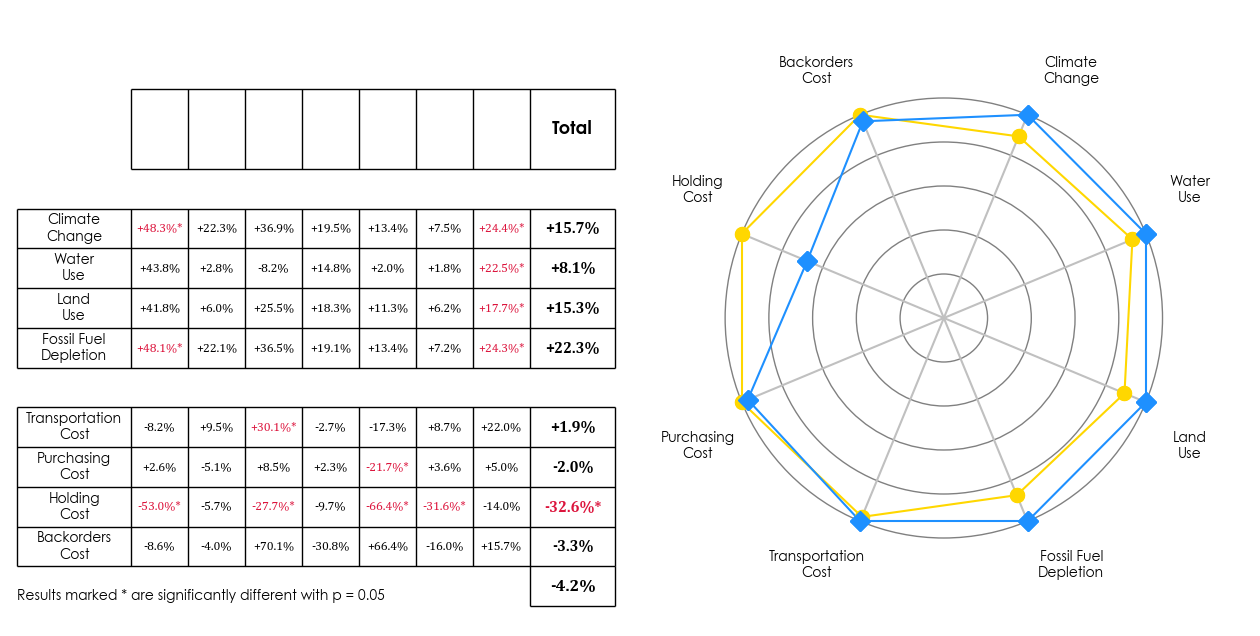

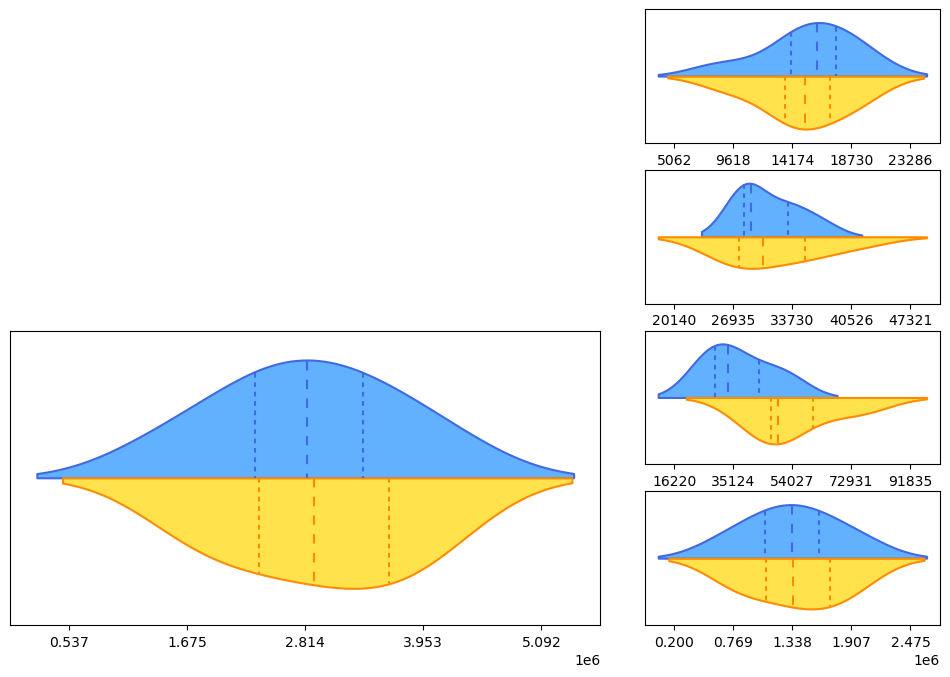

In [52]:
w = [0.5,0.125,0.125,0.125,0.125]
sustainability_evaluation(w)
costs_performance(w)